In [ ]:
import torch
from torch import Tensor
import numpy as np
from torch import nn
import dlc_bci as bci
from torch.autograd import Variable
from torch import optim
from torch.nn import functional as F
from matplotlib.pyplot import plot
%matplotlib inline

In [ ]:
# # #data augmentation..overfitting watch out carefully
# all_train = np.loadtxt('/Users/ana/Desktop/deeplearning/proj1-dl/resources/sp1s_aa_train.txt')
# y_train, X_train = all_train[:,0], all_train[:,1:]
# y_test, X_test = np.loadtxt('/Users/ana/Desktop/deeplearning/proj1-dl/resources/labels_data_set_iv.txt'), np.loadtxt('/Users/ana/Desktop/deeplearning/proj1-dl/resources/sp1s_aa_test.txt')

### 0. Data loading and preprocessing

#### Data loading

In [ ]:
train_input, train_target = bci.load(root = './data_bci')
print(str(type(train_input)), train_input.size()) 
print(str(type(train_target)), train_target.size())
test_input , test_target = bci.load(root = './data_bci', train = False)
print(str(type(test_input)), test_input.size()) 
print(str(type(test_target)), test_target.size())

In [ ]:
train_input, train_target = Variable(train_input), Variable(train_target)
test_input, test_target = Variable(test_input), Variable(test_target)

#### Data normalization

In [ ]:
mu, std = train_input.mean(0), train_input.std(0)
train_input.sub_(mu).div_(std)
test_input.sub_(mu).div_(std)
print("Normalization is done!")

#### Utility functions

In [75]:
def train_model(model, train_input, train_target, nb_epochs = 200):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.01)
    costs = []
    
    for e in range(0, nb_epochs):
        cost = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            cost += loss.data[0]
            optimizer.step()
        costs.append(cost)
    return costs

def compute_nb_errors(model, data_input, data_target):

    nb_data_errors = 0

    for b in range(0, data_input.size(0), mini_batch_size):
        output = model(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes = torch.max(output.data, 1)
        for k in range(0, mini_batch_size):
            if data_target.data[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1

    return nb_data_errors

### 1. Linear model

### 2. Fully connected model

#### Create network

In [26]:
class FC_net(nn.Module):
    def __init__(self, layers):
        super(FC_net, self).__init__() 
        self.additional_hidden = nn.ModuleList()
        for l in range(len(layers)-1):
            self.additional_hidden.append(nn.Linear(layers[l], layers[l+1]))

    def forward(self, x):
        x=x.view(x.shape[0], -1)
        for l in range(len(self.additional_hidden)-1):
            x = F.relu(self.additional_hidden[l](x))
        x = self.additional_hidden[-1](x)
        return x

#### Train network

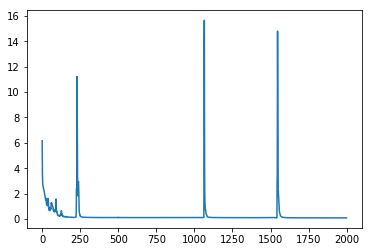

In [35]:
#check model parameters
layers = [train_input.view(train_input.shape[0], -1).shape[1], 5, 2]
model_fc = FC_net(layers)
for k in model_fc.parameters():
    print(k.size())
    
mini_batch_size = 79
nb_epochs = 2000
costs = train_model(model_fc, train_input, train_target, nb_epochs)
plot (range(nb_epochs), costs)

#### Assess network

In [36]:
mini_batch_size = 79
print('train_error {:.02f}%'.format(
            compute_nb_errors(model_fc, train_input, train_target) / train_input.size(0) * 100))
mini_batch_size = 20
print('test_error {:.02f}%'.format(
            compute_nb_errors(model_fc, test_input, test_target) / test_input.size(0) * 100))

# print("train data error = {}/316 %".format(compute_nb_errors(model, train_input, train_target))
# compute_nb_errors(model, test_input, test_target)

train_error 1.27%
test_error 31.00%


In [ ]:
#add regularisation

In [ ]:
#train model few times and take average, because of different initialization

### 3. Convolutional neural network

In [76]:
layers = [5, 2]
layers_conv = [28, 8]
kernel_size = [6]
pooling_kernel_size = [3]
class Conv_net(nn.Module):
    def __init__(self, layers, layers_conv, kernel_size, pooling_kernel_size):
        super(Conv_net, self).__init__()
        self.pooling_kernel_size = pooling_kernel_size
        self.additional_conv_hidden = nn.ModuleList()
        self.additional_fc_hidden = nn.ModuleList()
        for l in range(len(layers_conv)-1):
            self.additional_conv_hidden.append(nn.Conv1d(layers_conv[l], layers_conv[l+1], kernel_size=kernel_size[l]))
        size = train_input.shape[2]
        #print(size)
        for i in range(len(kernel_size)):
            size-=(kernel_size[i]-1)
            #print(size)
            size//=pooling_kernel_size[i]
            #print(size)
        #print(size)
        #print(layers_conv[-1])
        self.additional_fc_hidden.append(nn.Linear(size*layers_conv[-1], layers[0]))   
        self.flat_size = size*layers_conv[-1]
        
        for l in range(len(layers)-1):
            self.additional_fc_hidden.append(nn.Linear(layers[l], layers[l+1]))

    def forward(self, x):
        for l in range(len(self.additional_conv_hidden)):
            x = F.relu(F.max_pool1d(self.additional_conv_hidden[l](x), kernel_size=self.pooling_kernel_size[l]))
        x=x.view(-1, self.flat_size)
        for l in range(len(self.additional_fc_hidden)-1):
            x = F.relu(self.additional_fc_hidden[l](x))
        x = self.additional_fc_hidden[-1](x)
        return x

#### Train network

In [88]:
model_conv = Conv_net(layers, layers_conv, kernel_size, pooling_kernel_size)
for k in model_conv.parameters():
    print(k.size())
    
mini_batch_size = 79
nb_epochs = 700
costs = train_model(model_conv, train_input, train_target, nb_epochs)

torch.Size([8, 28, 6])
torch.Size([8])
torch.Size([5, 120])
torch.Size([5])
torch.Size([2, 5])
torch.Size([2])


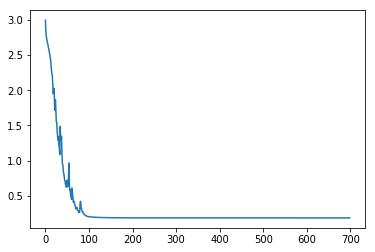

In [89]:
plot (range(nb_epochs), costs)

In [90]:
mini_batch_size = 79
print('train_error {:.02f}%'.format(
            compute_nb_errors(model_conv, train_input, train_target) / train_input.size(0) * 100))
mini_batch_size = 20
print('test_error {:.02f}%'.format(
            compute_nb_errors(model_conv, test_input, test_target) / test_input.size(0) * 100))

train_error 0.95%
test_error 25.00%
